In [1]:
from scipy.io import loadmat,savemat
import tensorflow as tf
import os
import random
import numpy as np
import glob
from tqdm import tqdm 
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 45
np.random.seed=seed

In [3]:
# Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes = 3  # Number of classes for segmentation

# Define paths
image_dir = "Images/"
mask_dir = "Semi-automatic-annotations/"

# Capture training image info as a list
train_images = []
train_masks = []

# List all image files
image_files = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))

for img_path in image_files:
    # Read image
    img = cv2.imread(img_path, 0)  # Read as grayscale
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    train_images.append(img)
    
    # Construct the corresponding mask path
    base_name = os.path.basename(img_path).split('.')[0]  # Extract the base name without extension
    mask_path = os.path.join(mask_dir, base_name + '.mat')
    
    # Read mask
    if os.path.exists(mask_path):
        mask_data = loadmat(mask_path)
        # Assuming the mask is stored in a variable named 'mask' within the .mat file
        mask = mask_data['mask']
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
        train_masks.append(mask)
    else:
        print(f"Mask not found for image {img_path}")

# Convert lists to arrays for machine learning processing        
train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Verify the shapes
print("Shape of train_images:", train_images.shape)
print("Shape of train_masks:", train_masks.shape)



Shape of train_images: (650, 128, 128)
Shape of train_masks: (650, 128, 128)


In [4]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

#################################################
train_images = np.expand_dims(train_images, axis=3)
train_images = train_images/255

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
# Verify the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("y_test_cat shape:", y_test_cat.shape)

F:\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class values in the dataset are ...  [0 1 2]
X_train shape: (468, 128, 128, 1)
X_test shape: (65, 128, 128, 1)
y_train_cat shape: (468, 128, 128, 3)
y_test_cat shape: (65, 128, 128, 3)


In [9]:
# Build ResUNet++ model
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
def SE(inputs, ratio=8):
    channel_axis = -1
    num_filters = inputs.shape[channel_axis]
    se_shape = (1, 1, num_filters)

    x = L.GlobalAveragePooling2D()(inputs)
    x = L.Reshape(se_shape)(x)
    x = L.Dense(num_filters // ratio, activation='relu', use_bias=False)(x)
    x = L.Dense(num_filters, activation='sigmoid', use_bias=False)(x)

    x = L.Multiply()([inputs, x])
    return x

def stem_block(inputs, num_filters):
    x = L.Conv2D(num_filters, 3, padding="same")(inputs)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)

    s = L.Conv2D(num_filters, 1, padding="same")(inputs)

    x = L.Add()([x, s])
    return x

def resnet_block(inputs, num_filters, strides=1):
    inputs = SE(inputs)

    x = L.BatchNormalization()(inputs)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same", strides=strides)(x)

    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same", strides=1)(x)

    s = L.Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    x = L.Add()([x, s])

    return x

def aspp_block(inputs, num_filters):
    x1 = L.Conv2D(num_filters, 3, dilation_rate=6, padding="same")(inputs)
    x1 = L.BatchNormalization()(x1)

    x2 = L.Conv2D(num_filters, 3, dilation_rate=12, padding="same")(inputs)
    x2 = L.BatchNormalization()(x2)

    x3 = L.Conv2D(num_filters, 3, dilation_rate=18, padding="same")(inputs)
    x3 = L.BatchNormalization()(x3)

    x4 = L.Conv2D(num_filters, (3, 3), padding="same")(inputs)
    x4 = L.BatchNormalization()(x4)

    y = L.Add()([x1, x2, x3, x4])
    y = L.Conv2D(num_filters, 1, padding="same")(y)

    return y

def attention_block(x1, x2):
    num_filters = x2.shape[-1]

    x1_conv = L.BatchNormalization()(x1)
    x1_conv = L.Activation("relu")(x1_conv)
    x1_conv = L.Conv2D(num_filters, 3, padding="same")(x1_conv)
    x1_pool = L.MaxPooling2D((2, 2))(x1_conv)

    x2_conv = L.BatchNormalization()(x2)
    x2_conv = L.Activation("relu")(x2_conv)
    x2_conv = L.Conv2D(num_filters, 3, padding="same")(x2_conv)

    x = L.Add()([x1_pool, x2_conv])

    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)

    x = L.Multiply()([x, x2])
    return x

def resunet_pp(input_shape):
    inputs = L.Input(input_shape)

    c1 = stem_block(inputs, 16)
    c2 = resnet_block(c1, 32, strides=2)
    c3 = resnet_block(c2, 64, strides=2)
    c4 = resnet_block(c3, 128, strides=2)

    b1 = aspp_block(c4, 256)

    d1 = attention_block(c3, b1)
    d1 = L.UpSampling2D((2, 2))(d1)
    d1 = L.Concatenate()([d1, c3])
    d1 = resnet_block(d1, 128)

    d2 = attention_block(c2, d1)
    d2 = L.UpSampling2D((2, 2))(d2)
    d2 = L.Concatenate()([d2, c2])
    d2 = resnet_block(d2, 64)

    d3 = attention_block(c1, d2)
    d3 = L.UpSampling2D((2, 2))(d3)
    d3 = L.Concatenate()([d3, c1])
    d3 = resnet_block(d3, 32)

    outputs = aspp_block(d3, 16)
    outputs = L.Conv2D(n_classes, 1, padding="same")(outputs)
    outputs = L.Activation("softmax")(outputs)

    model = Model(inputs, outputs)
    return model

# Instantiate and compile the model
input_shape=(128,128,1)
model = resunet_pp(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 16)      │             160 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 128, 128, 16)      │              64 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 128, 128, 16)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 16)      │           2,320 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 16)      │              32 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 128, 128, 16)      │               0 │ conv2d_1[0][0],            │
│                               │                           │                 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d      │ (None, 16)                │               0 │ add[0][0]                  │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 1, 16)          │               0 │ global_average_pooling2d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1, 1, 2)           │              32 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1, 1, 16)          │              32 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply (Multiply)           │ (None, 128, 128, 16)      │               0 │ add[0][0], dense_1[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 128, 128, 16)      │              64 │ multiply[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 128, 128, 16)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 32)        │           4,640 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,092,371 (15.61 MB)

 Trainable params: 4,085,907 (15.59 MB)

 Non-trainable params: 6,464 (25.25 KB)

In [11]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=15, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 267s 13s/step - accuracy: 0.7547 - loss: 1.1656 - val_accuracy: 0.9836 - val_loss: 0.8430
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 192s 13s/step - accuracy: 0.9814 - loss: 0.7828 - val_accuracy: 0.9836 - val_loss: 0.5490
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 193s 13s/step - accuracy: 0.9829 - loss: 0.4806 - val_accuracy: 0.9836 - val_loss: 0.2876
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 191s 13s/step - accuracy: 0.9834 - loss: 0.2486 - val_accuracy: 0.9836 - val_loss: 0.1533
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 198s 13s/step - accuracy: 0.9840 - loss: 0.1384 - val_accuracy: 0.9836 - val_loss: 0.1108
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 207s 14s/step - accuracy: 0.9840 - loss: 0.1077 - val_accuracy: 0.9836 - val_loss: 0.0997
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 195s 13s/step - accuracy: 0.9842 - loss: 0.0967 - val_accuracy: 0.9836 - val_loss: 0.0966
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 207s 14s/step - accuracy: 0.9842 - loss: 0.0933 - val_accuracy: 0.

In [13]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9837 - loss: 0.0944
Accuracy is =  98.35721254348755 %


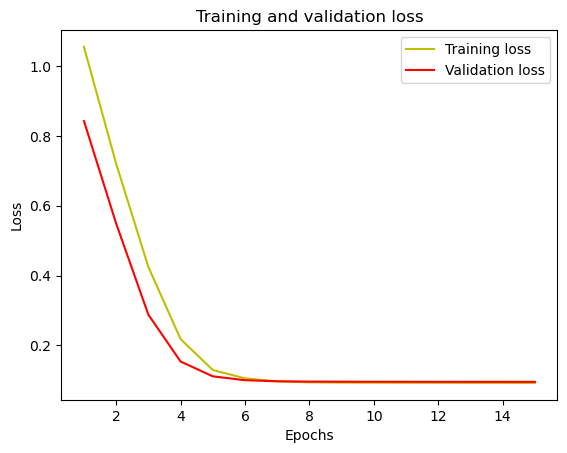

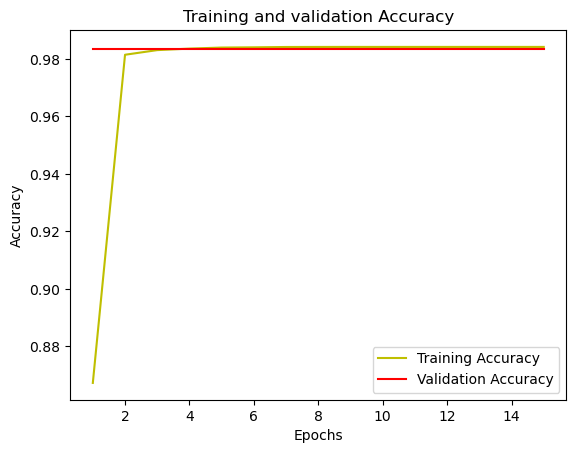

In [15]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


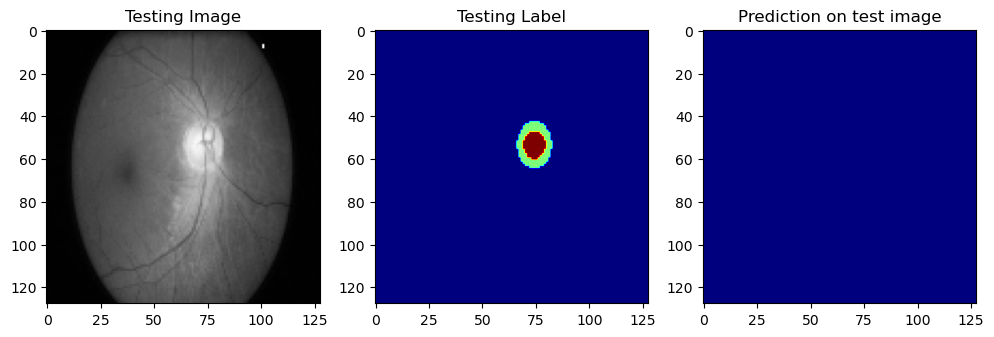

In [17]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()